# Getting started with PyMC3 

Based on notebook by John Salvatier, Thomas V. Wiecki, Christopher Fonnesbeck from [https://docs.pymc.io/notebooks/getting_started.html].

## Features of PyMC3

* PyMC3 is an open source Probabilistic Programming framework written in Python.  It uses Theano to calculated gradients it needs for HMC using automatic differentiation. 
* PyMC3 compiles probabilistic programs on-the-fly to C for increased speed.
* It allows models to be specified directly in Python (cf. PyStan) with intuitive and readable syntax, that mimics the synta used by statisticians.
* "It features next-generation Markov chain Monte Carlo (MCMC) sampling algorithms such as the No-U-Turn Sampler (NUTS; Hoffman, 2014), a self-tuning variant of Hamiltonian Monte Carlo (HMC; Duane, 1987). This class of samplers works well on high dimensional and complex posterior distributions and allows many complex models to be fit without specialized knowledge about fitting algorithms."
* NUTS has self-tuning strategies to set HMC tunable parameters adaptively.
* About Theano: "Theano is a library that allows expressions to be defined using generalized vector data structures called *tensors*, which are tightly integrated with the popular NumPy `ndarray` data structure, and similarly allow for broadcasting and advanced indexing, just as NumPy arrays do. Theano also automatically optimizes the likelihood's computational graph for speed and provides simple GPU integration."


## A Motivating Example: Linear Regression

To introduce model definition, fitting and posterior analysis, we first consider a simple Bayesian linear regression model with normal priors for the parameters. We are interested in predicting outcomes $Y$ as normally-distributed observations with an expected value $\mu$ that is a linear function of two predictor variables, $X_1$ and $X_2$.

$$\begin{aligned} 
Y  &\sim \mathcal{N}(\mu, \sigma^2) \\
\mu &= \alpha + \beta_1 X_1 + \beta_2 X_2
\end{aligned}$$

where $\alpha$ is the intercept, and $\beta_i$ is the coefficient for covariate $X_i$, while $\sigma$ represents the observation error. Since we are constructing a Bayesian model, we must assign a prior distribution to the unknown variables in the model. We choose zero-mean normal priors with variance of 100 for both regression coefficients, which corresponds to *weak* information regarding the true parameter values. We choose a half-normal distribution (normal distribution bounded at zero) as the prior for $\sigma$.

$$\begin{aligned} 
\alpha &\sim \mathcal{N}(0, 100) \\
\beta_i &\sim \mathcal{N}(0, 100) \\
\sigma &\sim \lvert\mathcal{N}(0, 1){\rvert}
\end{aligned}$$

### Generating data

We can simulate some artificial data from this model using only NumPy's `random` module, and then use PyMC3 to try to recover the corresponding parameters. We are intentionally generating the data to closely correspond the PyMC3 model structure.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

# Initialize random number generator
np.random.seed(123)

# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma

Here is what the simulated data look like. 

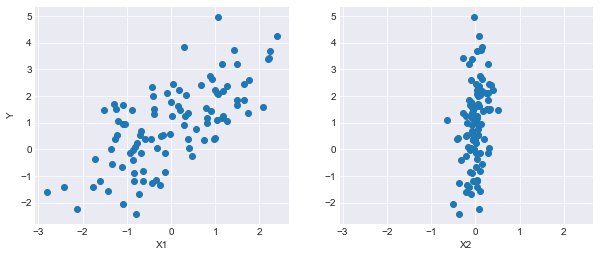

In [2]:
%matplotlib inline 

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,4))
axes[0].scatter(X1, Y)
axes[1].scatter(X2, Y)
axes[0].set_ylabel('Y'); axes[0].set_xlabel('X1'); axes[1].set_xlabel('X2');

### Model Specification

Specifying this model in PyMC3 is straightforward because the syntax is as close to the statistical notation. For the most part, each line of Python code corresponds to a line in the model notation above. 

First, we import PyMC. We use the convention of importing it as `pm`.

In [3]:
import pymc3 as pm
print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.7


Now we build our model, which we will present in full first, then explain each part line-by-line.

In [4]:
basic_model = pm.Model()

with basic_model:
    
    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    sigma = pm.HalfNormal('sigma', sd=1)
    
    # Expected value of outcome
    mu = alpha + beta[0]*X1 + beta[1]*X2
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigma, observed=Y)

The first line,

```python
basic_model = Model()
```

creates a new `Model` object which is a container for the model random variables.

Following instantiation of the model, the subsequent specification of the model components is performed inside a  `with` statement:

```python
with basic_model:
```
This creates a *context manager*, with our `basic_model` as the context, that includes all statements until the indented block ends. This means all PyMC3 objects introduced in the indented code block below the `with` statement are added to the model behind the scenes. Absent this context manager idiom, we would be forced to manually associate each of the variables with `basic_model` right after we create them. If you try to create a new random variable without a `with model:` statement, it will raise an error since there is no obvious model for the variable to be added to.

The first three statements in the context manager:

```python
alpha = Normal('alpha', mu=0, sd=10)
beta = Normal('beta', mu=0, sd=10, shape=2)
sigma = HalfNormal('sigma', sd=1)
```
create **stochastic** random variables with Normal prior distributions for the regression coefficients with a mean of 0 and standard deviation of 10, and a half-normal distribution for the standard deviation of the observations, $\sigma$. These are stochastic because their values are partly determined by its parents in the dependency graph of random variables, which for priors are simple constants, and partly random (or stochastic). 

We call the `Normal` constructor to create a random variable to use as a normal prior. The first argument is always the *name* of the random variable, which should almost always match the name of the Python variable being assigned to, since it is sometimes used to retrieve the variable from the model for summarizing output. The remaining required arguments for a stochastic object are the parameters, in this case `mu`, the mean, and `sd`, the standard deviation, which we assign hyperparameter values for the model. In general, a distribution's parameters are values that determine the location, shape or scale of the random variable, depending on the parameterization of the distribution. Most commonly used distributions, such as `Beta`, `Exponential`, `Categorical`, `Gamma`, `Binomial` and many others, are available in PyMC3.

The `beta` variable has an additional `shape` argument to denote it as a vector-valued parameter of size 2. The `shape` argument is available for all distributions and specifies the length or shape of the random variable, but is optional for scalar variables, since it defaults to a value of one. It can be an integer, to specify an array, or a tuple, to specify a multidimensional array (*e.g.* `shape=(5,7)` makes random variable that takes on 5 by 7 matrix values). 

Detailed notes about distributions, sampling methods and other PyMC3 functions are available in the [API documentation](https://docs.pymc.io/api.html).

Having defined the priors, the next statement creates the expected value `mu` of the outcomes, specifying the linear relationship:

```python
mu = alpha + beta[0]*X1 + beta[1]*X2
```
This creates a **deterministic** random variable, which implies that its value is *completely* determined by its parents' values. That is, there is no uncertainty beyond that which is inherent in the parents' values. Here, `mu` is just the sum of the intercept `alpha` and the two products of the coefficients in `beta` and the predictor variables, whatever their values may be. 

PyMC3 random variables and data can be arbitrarily added, subtracted, divided, multiplied together and indexed-into to create new random variables. This allows for great model expressivity. Many common mathematical functions like `sum`, `sin`, `exp` and linear algebra functions like `dot` (for inner product) and `inv` (for inverse) are also provided. 

The final line of the model, defines `Y_obs`, the sampling distribution of the outcomes in the dataset.

```python
Y_obs = Normal('Y_obs', mu=mu, sd=sigma, observed=Y)
```

This is a special case of a stochastic variable that we call an **observed stochastic**, and represents the data likelihood of the model. It is identical to a standard stochastic, except that its `observed` argument, which passes the data to the variable, indicates that the values for this variable were observed, and should not be changed by any fitting algorithm applied to the model. The data can be passed in the form of either a `numpy.ndarray` or `pandas.DataFrame` object.

Notice that, unlike for the priors of the model, the parameters for the normal distribution of `Y_obs` are not fixed values, but rather are the deterministic object `mu` and the stochastic `sigma`. This creates parent-child relationships between the likelihood and these two variables.

### Model fitting

Having completely specified our model, the next step is to obtain posterior estimates for the unknown variables in the model. Ideally, we could calculate the posterior estimates analytically, but for most non-trivial models, this is not feasible. We will consider two approaches, whose appropriateness depends on the structure of the model and the goals of the analysis: finding the *maximum a posteriori* (MAP) point using optimization methods, and computing summaries based on samples drawn from the posterior distribution using Markov Chain Monte Carlo (MCMC) sampling methods.

#### Maximum a posteriori methods

The **maximum a posteriori (MAP)** estimate for a model, is the mode of the posterior distribution and is generally found using numerical optimization methods. This is often fast and easy to do, but only gives a point estimate for the parameters and can be biased if the mode isn't representative of the distribution. PyMC3 provides this functionality with the `find_MAP` function.

Below we find the MAP for our original model. The MAP is returned as a parameter **point**, which is always represented by a Python dictionary of variable names to NumPy arrays of parameter values. 

In [5]:
map_estimate = pm.find_MAP(model=basic_model)
    
map_estimate

/Users/furnstah/anaconda3/envs/talent-env/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -149.58, ||grad|| = 12.242: 100%|██████████| 19/19 [00:00<00:00, 974.72it/s]  


{'alpha': array(0.90660093),
 'beta': array([0.94848596, 2.60711845]),
 'sigma_log__': array(-0.03771373),
 'sigma': array(0.96298858)}

By default, `find_MAP` uses the Broyden–Fletcher–Goldfarb–Shanno (BFGS) optimization algorithm to find the maximum of the log-posterior but also allows selection of other optimization algorithms from the `scipy.optimize` module. For example, below we use Powell's method to find the MAP.

In [6]:
map_estimate = pm.find_MAP(model=basic_model, method='powell')
    
map_estimate

/Users/furnstah/anaconda3/envs/talent-env/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
  0%|          | 0/5000 [00:00<?, ?it/s]/Users/furnstah/anaconda3/envs/talent-env/lib/python3.7/site-packages/scipy/optimize/_minimize.py:500: RuntimeWarning: Method powell does not use gradient information (jac).
  RuntimeWarning)
logp = -149.47, ||grad|| = 13.248: 100%|██████████| 177/177 [00:00<00:00, 1293.94it/s] 


{'alpha': array(0.90907964),
 'beta': array([0.9514399 , 2.61452795]),
 'sigma_log__': array(-0.03492212),
 'sigma': array(0.96568062)}

It is important to note that the MAP estimate is not always reasonable, especially if the mode is at an extreme. This can be a subtle issue; with high dimensional posteriors, one can have areas of extremely high density but low total probability because the volume is very small. This will often occur in hierarchical models with the variance parameter for the random effect. If the individual group means are all the same, the posterior will have near infinite density if the scale parameter for the group means is almost zero, even though the probability of such a small scale parameter will be small since the group means must be extremely close together. 

Most techniques for finding the MAP estimate also only find a *local* optimum (which is often good enough), but can fail badly for multimodal posteriors if the different modes are meaningfully different.

In summary, while PyMC3 provides the function `find_MAP()`, at this point mostly for historical reasons, this function is of little use in most scenarios. If you want a point estimate you should get it from the posterior. In the next section we will see how to get a posterior using sampling methods.

#### Sampling methods

Though finding the MAP is a fast and easy way of obtaining estimates of the unknown model parameters, it is limited because there is no associated estimate of uncertainty produced with the MAP estimates. Instead, a simulation-based approach such as Markov chain Monte Carlo (MCMC) can be used to obtain a Markov chain of values that, given the satisfaction of certain conditions, are indistinguishable from samples from the _true_ posterior distribution. 

To conduct MCMC sampling to generate posterior samples in PyMC3, we specify a **step method** object that corresponds to a particular MCMC algorithm, such as Metropolis, Slice sampling, or the No-U-Turn Sampler (NUTS). PyMC3's `step_methods` submodule contains the following samplers: `NUTS`, `Metropolis`, `Slice`, `HamiltonianMC`, and `BinaryMetropolis`. These step methods can be assigned manually, or assigned automatically by PyMC3. Auto-assignment is based on the attributes of each variable in the model. In general:

* Binary variables will be assigned to `BinaryMetropolis`
* Discrete variables will be assigned to `Metropolis`
* Continuous variables will be assigned to `NUTS`

Auto-assignment can be overriden for any subset of variables by specifying them manually prior to sampling.

#### Gradient-based sampling methods

PyMC3 has the standard sampling algorithms like adaptive Metropolis-Hastings and adaptive slice sampling, but PyMC3's most capable step method is the No-U-Turn Sampler. NUTS is especially useful on models that have many continuous parameters, a situation where other MCMC algorithms work very slowly. It takes advantage of information about where regions of higher probability are, based on the gradient of the log posterior-density. This helps it achieve dramatically faster convergence on large problems than traditional sampling methods achieve. PyMC3 relies on Theano to analytically compute model gradients via automatic differentiation of the posterior density. NUTS also has several self-tuning strategies for adaptively setting the tunable parameters of Hamiltonian Monte Carlo. For random variables that are undifferentiable (namely, discrete variables) NUTS cannot be used, but it may still be used on the differentiable variables in a model that contains undifferentiable variables. 

NUTS requires a scaling matrix parameter, which is analogous to the variance parameter for the jump proposal distribution in Metropolis-Hastings, although NUTS uses it somewhat differently. The matrix gives the rough shape of the distribution so that NUTS does not make jumps that are too large in some directions and too small in other directions. It is important to set this scaling parameter to a reasonable value to facilitate efficient sampling. This is especially true for models that have many unobserved stochastic random variables or models with highly non-normal posterior distributions. Poor scaling parameters will slow down NUTS significantly, sometimes almost stopping it completely. A reasonable starting point for sampling can also be important for efficient sampling, but not as often.

`PyMC3` automatically initializes NUTS to reasonable values based on the variance of the samples obtained during a tuning phase. A little bit of noise is added to ensure different, parallel, chains start from different points. Also, `PyMC3` will automatically assign an appropriate sampler if we don't supply it via the `step` keyword argument (see below for an example of how to explicitly assign step methods).

In [7]:
with basic_model:
    # draw 500 posterior samples
    trace = pm.sample(500) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1167.99draws/s]


The `sample` function runs the step method(s) assigned (or passed) to it for the given number of iterations and returns a `Trace` object containing the samples collected, in the order they were collected. The `trace` object can be queried in a similar way to a `dict` containing a map from variable names to `numpy.array`s. The first dimension of the array is the sampling index and the later dimensions match the shape of the variable. We can see the last 5 values for the `alpha` variable as follows:

In [8]:
trace['alpha'][-5:]

array([0.9022226 , 0.87236601, 0.96473987, 0.79315611, 0.67644667])

If we wanted to use the slice sampling algorithm to `sigma` instead of NUTS (which was assigned automatically), we could have specified this as the `step` argument for `sample`.

In [9]:
with basic_model:

    # instantiate sampler
    step = pm.Slice() 
    
    # draw 5000 posterior samples
    trace = pm.sample(5000, step=step)   

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [sigma]
>Slice: [beta]
>Slice: [alpha]
Sampling 4 chains: 100%|██████████| 22000/22000 [00:30<00:00, 733.14draws/s] 


### Posterior analysis
`PyMC3` provides plotting and summarization functions for inspecting the sampling output. A simple posterior plot can be created using `traceplot`.

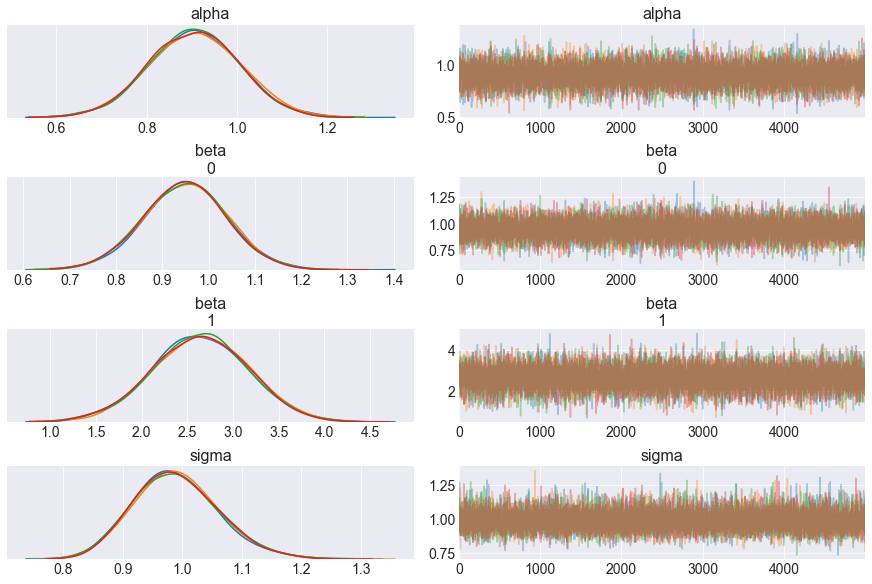

In [10]:
pm.traceplot(trace);

The left column consists of a smoothed histogram (using kernel density estimation) of the marginal posteriors of each stochastic random variable while the right column contains the samples of the Markov chain plotted in sequential order. The `beta` variable, being vector-valued, produces two histograms and two sample traces, corresponding to both predictor coefficients.

In addition, the `summary` function provides a text-based output of common posterior statistics:

In [11]:
pm.summary(trace).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,0.91,0.10,0.0,0.72,1.11,19979.81,1.0
beta__0,0.95,0.09,0.0,0.78,1.13,19107.16,1.0
beta__1,2.65,0.52,0.0,1.60,3.65,16191.09,1.0
sigma,0.99,0.07,0.0,0.86,1.13,17898.13,1.0


## Case study 1: Stochastic volatility

We present a case study of stochastic volatility, time varying stock market volatility, to illustrate PyMC3's use in addressing a more realistic problem. The distribution of market returns is highly non-normal, which makes sampling the volatilities significantly more difficult. This example has 400+ parameters so using common sampling algorithms like Metropolis-Hastings would get bogged down, generating highly autocorrelated samples. Instead, we use NUTS, which is dramatically more efficient.

### The Model

Asset prices have time-varying volatility (variance of day over day `returns`). In some periods, returns are highly variable, while in others they are very stable. Stochastic volatility models address this with a latent volatility variable, which changes over time. The following model is similar to the one described in the NUTS paper (Hoffman 2014, p. 21).

$$
\begin{aligned} 
  \nu &\sim exp(0.1) \\
  \sigma &\sim exp(50) \\
  s_i &\sim \mathcal{N}(s_{i-1}, \sigma^2) \\
  log(r_i) &\sim t(\nu, 0, exp(-2 s_i))
\end{aligned}
$$

Here, $r$ is the daily return series which is modeled with a Student-t distribution with an unknown degrees of freedom parameter, and a scale parameter determined by a latent process $s$. The individual $s_i$ are the individual daily log volatilities in the latent log volatility process. 

### The Data

Our data consist of 401 daily returns of the S&P 500 stock market index during the 2008 financial crisis.

In [12]:
import pandas as pd

returns = pd.read_csv(pm.get_data('SP500.csv'), parse_dates=True, index_col=0)

len(returns)

401

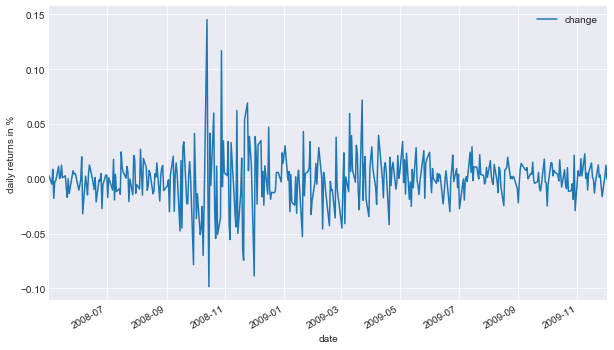

In [13]:
returns.plot(figsize=(10, 6))
plt.ylabel('daily returns in %');

### Model Specification

As with the linear regression example, specifying the model in PyMC3 mirrors its statistical specification. This model employs several new distributions: the `Exponential` distribution for the $\nu$ and $\sigma$ priors, the Student-T (`StudentT`) distribution for distribution of returns, and the `GaussianRandomWalk` for the prior for the latent volatilities.   

In PyMC3, variables with purely positive priors like `Exponential` are transformed with a log transform. This makes sampling more robust. Behind the scenes, a variable in the unconstrained space (named "variableName_log") is added to the model for sampling. In this model this happens behind the scenes for both the degrees of freedom, `nu`, and the scale parameter for the volatility process, `sigma`, since they both have exponential priors. Variables with priors that constrain them on two sides, like `Beta` or `Uniform`, are also transformed to be unconstrained but with a log odds transform. 

Although, unlike model specification in PyMC2, we do not typically provide starting points for variables at the model specification stage, we can also provide an initial value for any distribution (called a "test value") using the `testval` argument. This overrides the default test value for the distribution (usually the mean, median or mode of the distribution), and is most often useful if some values are illegal and we want to ensure we select a legal one. The test values for the distributions are also used as a starting point for sampling and optimization by default, though this is easily overriden. 

The vector of latent volatilities `s` is given a prior distribution by `GaussianRandomWalk`. As its name suggests GaussianRandomWalk is a vector valued distribution where the values of the vector form a random normal walk of length n, as specified by the `shape` argument. The scale of the innovations of the random walk, `sigma`, is specified in terms of the standard deviation of the normally distributed innovations and can be a scalar or vector. 

In [14]:
with pm.Model() as sp500_model:
    nu = pm.Exponential('nu', 1/10., testval=5.)
    sigma = pm.Exponential('sigma', 1/0.02, testval=.1)

    s = pm.GaussianRandomWalk('s', sd=sigma, shape=len(returns))
    volatility_process = pm.Deterministic('volatility_process', pm.math.exp(-2*s)**0.5)

    r = pm.StudentT('r', nu=nu, sd=volatility_process, observed=returns['change'])

Notice that we transform the log volatility process `s` into the volatility process by `exp(-2*s)`. Here, `exp` is a Theano function, rather than the corresponding function in NumPy; Theano provides a large subset of the mathematical functions that NumPy does.

Also note that we have declared the `Model` name `sp500_model` in the first occurrence of the context manager, rather than splitting it into two lines, as we did for the first example.

### Fitting

In [15]:
with sp500_model:
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [s, sigma, nu]
Sampling 4 chains: 100%|██████████| 10000/10000 [03:12<00:00, 51.88draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


We can check our samples by looking at the traceplot for `nu` and `sigma`.

/Users/furnstah/anaconda3/envs/talent-env/lib/python3.7/site-packages/pymc3/plots/__init__.py:40: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


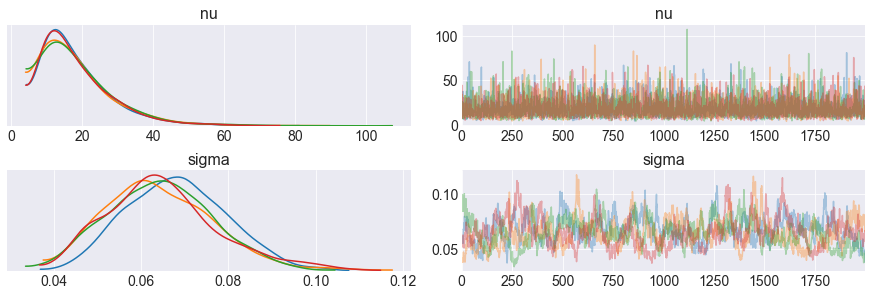

In [16]:
pm.traceplot(trace, varnames=['nu', 'sigma']);

Finally we plot the distribution of volatility paths by plotting many of our sampled volatility paths on the same graph. Each is rendered partially transparent (via the `alpha` argument in Matplotlib's `plot` function) so the regions where many paths overlap are shaded more darkly.

/Users/furnstah/anaconda3/envs/talent-env/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/furnstah/anaconda3/envs/talent-env/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


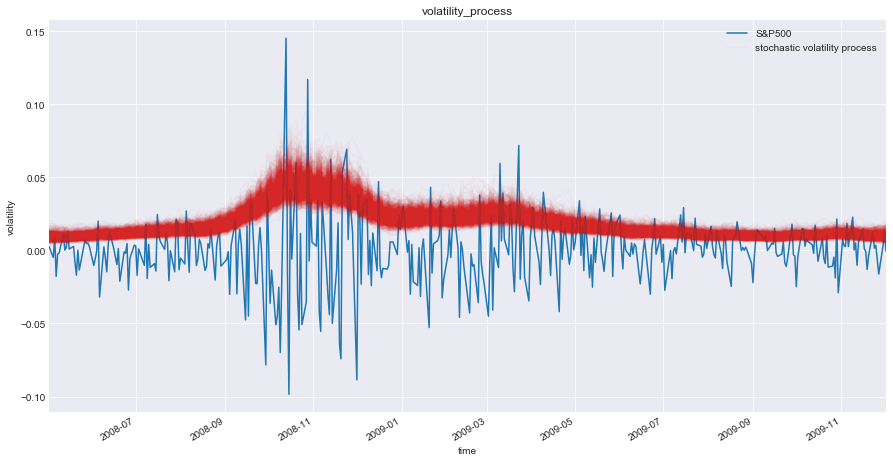

In [17]:
fig, ax = plt.subplots(figsize=(15, 8))
returns.plot(ax=ax)
ax.plot(returns.index, 1/np.exp(trace['s',::5].T), 'C3', alpha=.03);
ax.set(title='volatility_process', xlabel='time', ylabel='volatility');
ax.legend(['S&P500', 'stochastic volatility process']);

As you can see, the model correctly infers the increase in volatility during the 2008 financial crash. Moreover, note that this model is quite complex because of its high dimensionality and dependency-structure in the random walk distribution. NUTS as implemented in PyMC3, however, correctly infers the posterior distribution with ease.

## Case study 2: Coal mining disasters

Consider the following time series of recorded coal mining disasters in the UK from 1851 to 1962 (Jarrett, 1979). The number of disasters is thought to have been affected by changes in safety regulations during this period. Unfortunately, we also have pair of years with missing data, identified as missing by a `nan` in the pandas `Series`. These missing values will be automatically imputed by `PyMC3`. 

Next we will build a model for this series and attempt to estimate when the change occurred. At the same time, we will see how to handle missing data, use multiple samplers and sample from discrete random variables. 

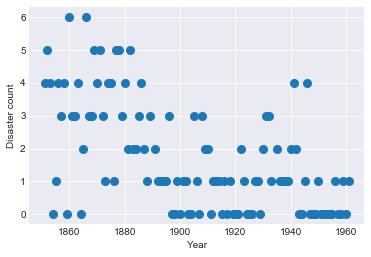

In [18]:
import pandas as pd
disaster_data = pd.Series([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                           3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                           2, 2, 3, 4, 2, 1, 3, np.nan, 2, 1, 1, 1, 1, 3, 0, 0,
                           1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                           0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                           3, 3, 1, np.nan, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                           0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])
years = np.arange(1851, 1962)

plt.plot(years, disaster_data, 'o', markersize=8);
plt.ylabel("Disaster count")
plt.xlabel("Year");

Occurrences of disasters in the time series is thought to follow a Poisson process with a large rate parameter in the early part of the time series, and from one with a smaller rate in the later part. We are interested in locating the change point in the series, which perhaps is related to changes in mining safety regulations.

In our model, 

$$ 
\begin{aligned}  
  D_t &\sim \text{Pois}(r_t), r_t= \begin{cases} 
   e, & \text{if } t \le s \\
   l, & \text{if } t \gt s 
   \end{cases} \\
  s &\sim \text{Unif}(t_l, t_h)\\         
  e &\sim \text{exp}(1)\\
  l &\sim \text{exp}(1)    
\end{aligned}
$$

the parameters are defined as follows: 
   * $D_t$: The number of disasters in year $t$
   * $r_t$: The rate parameter of the Poisson distribution of disasters in year $t$.
   * $s$: The year in which the rate parameter changes (the switchpoint).
   * $e$: The rate parameter before the switchpoint $s$.
   * $l$: The rate parameter after the switchpoint $s$.
   * $t_l$, $t_h$: The lower and upper boundaries of year $t$.
   
This model is built much like our previous models. The major differences are the introduction of discrete variables with the Poisson and discrete-uniform priors and the novel form of the deterministic random variable `rate`.

In [19]:
with pm.Model() as disaster_model:

    switchpoint = pm.DiscreteUniform('switchpoint', lower=years.min(), upper=years.max(), testval=1900)

    # Priors for pre- and post-switch rates number of disasters
    early_rate = pm.Exponential('early_rate', 1)
    late_rate = pm.Exponential('late_rate', 1)

    # Allocate appropriate Poisson rates to years before and after current
    rate = pm.math.switch(switchpoint >= years, early_rate, late_rate)

    disasters = pm.Poisson('disasters', rate, observed=disaster_data)

/Users/furnstah/anaconda3/envs/talent-env/lib/python3.7/site-packages/pymc3/model.py:1331: UserWarning: Data in disasters contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, UserWarning)


The logic for the rate random variable,
```python
rate = switch(switchpoint >= year, early_rate, late_rate)
```
is implemented using `switch`, a Theano function that works like an if statement. It uses the first argument to switch between the next two arguments.

Missing values are handled transparently by passing a `MaskedArray` or a `pandas.DataFrame` with NaN values to the `observed` argument when creating an observed stochastic random variable. Behind the scenes, another random variable, `disasters.missing_values` is created to model the missing values.

Unfortunately because they are discrete variables and thus have no meaningful gradient, we cannot use NUTS for sampling `switchpoint` or the missing disaster observations. Instead, we will sample using a `Metroplis` step method, which implements adaptive Metropolis-Hastings, because it is designed to handle discrete values. `PyMC3` automatically assigns the correct sampling algorithms.

In [20]:
with disaster_model:
    trace = pm.sample(10000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [disasters_missing]
>>Metropolis: [switchpoint]
>NUTS: [late_rate, early_rate]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:19<00:00, 2129.48draws/s]
The number of effective samples is smaller than 10% for some parameters.


In the trace plot below we can see that there's about a 10 year span that's plausible for a significant change in safety, but a 5 year span that contains most of the probability mass. The distribution is jagged because of the jumpy relationship between the year switchpoint and the likelihood  and not due to sampling error.

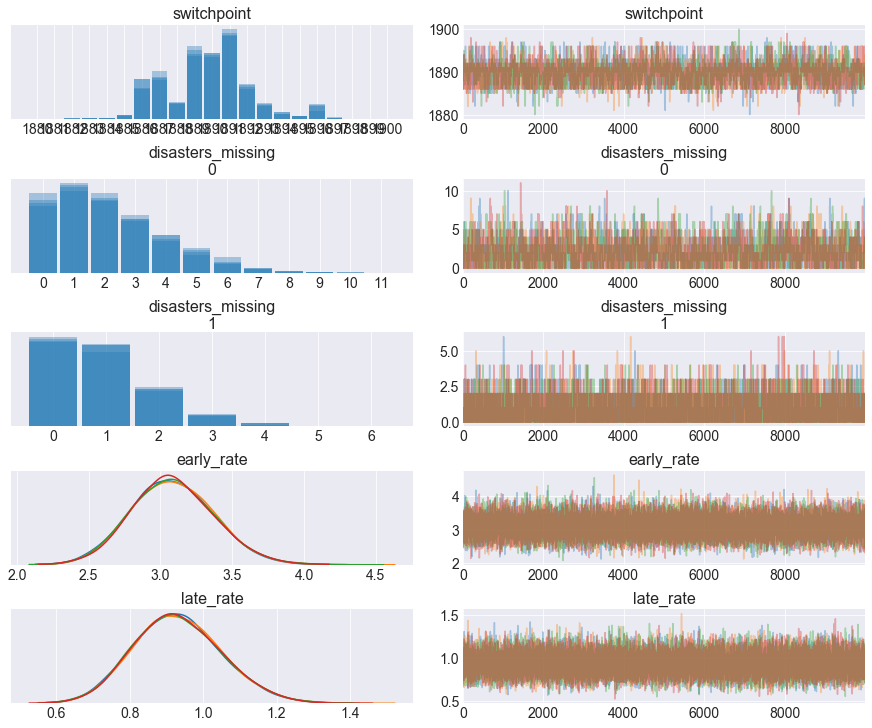

In [21]:
pm.traceplot(trace);

The following plot shows the switch point as an orange vertical line, together with its HPD as a semitransparent band. The dashed black line shows the accident rate.

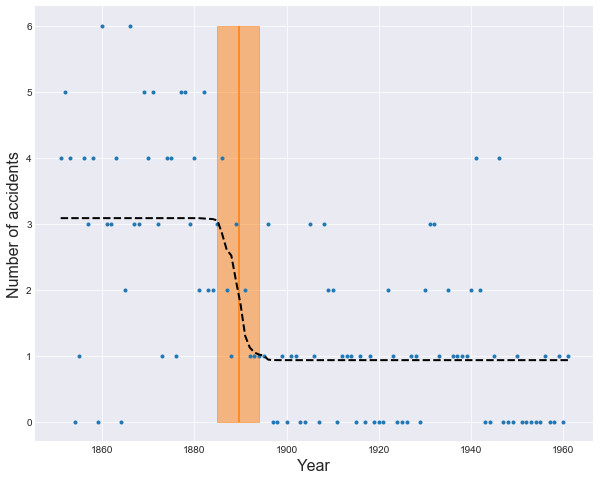

In [22]:
plt.figure(figsize=(10, 8))
plt.plot(years, disaster_data, '.')
plt.ylabel("Number of accidents", fontsize=16)
plt.xlabel("Year", fontsize=16)

plt.vlines(trace['switchpoint'].mean(), disaster_data.min(), disaster_data.max(), color='C1')
average_disasters = np.zeros_like(disaster_data, dtype='float')
for i, year in enumerate(years):
    idx = year < trace['switchpoint']
    average_disasters[i] = (trace['early_rate'][idx].sum() + trace['late_rate'][~idx].sum()) / (len(trace) * trace.nchains)

sp_hpd = pm.hpd(trace['switchpoint'])
plt.fill_betweenx(y=[disaster_data.min(), disaster_data.max()],
                  x1=sp_hpd[0], x2=sp_hpd[1], alpha=0.5, color='C1');
plt.plot(years, average_disasters,  'k--', lw=2);

## Arbitrary deterministics

Due to its reliance on Theano, PyMC3 provides many mathematical functions and operators for transforming random variables into new random variables. However, the library of functions in Theano is not exhaustive, therefore Theano and PyMC3 provide functionality for creating arbitrary Theano functions in pure Python, and including these functions in PyMC models. This is supported with the `as_op` function decorator.

Theano needs to know the types of the inputs and outputs of a function, which are specified for `as_op` by `itypes` for inputs and `otypes` for outputs. The Theano documentation includes [an overview of the available types](http://deeplearning.net/software/theano/library/tensor/basic.html#all-fully-typed-constructors).

In [23]:
import theano.tensor as tt
from theano.compile.ops import as_op

@as_op(itypes=[tt.lscalar], otypes=[tt.lscalar])
def crazy_modulo3(value):
    if value > 0: 
        return value % 3
    else :
        return (-value + 1) % 3
    
with pm.Model() as model_deterministic:
    a = pm.Poisson('a', 1)
    b = crazy_modulo3(a)

An important drawback of this approach is that it is not possible for `theano` to inspect these functions in order to compute the gradient required for the Hamiltonian-based samplers. Therefore, it is not possible to use the HMC or NUTS samplers for a model that uses such an operator. However, it is possible to add a gradient if we inherit from `theano.Op` instead of using `as_op`. The PyMC example set includes [a more elaborate example of the usage of as_op](https://github.com/pymc-devs/pymc3/blob/master/pymc3/examples/disaster_model_theano_op.py).

## Arbitrary distributions

Similarly, the library of statistical distributions in PyMC3 is not exhaustive, but PyMC3 allows for the creation of user-defined functions for an arbitrary probability distribution. For simple statistical distributions, the `DensityDist` function takes as an argument any function that calculates a log-probability $log(p(x))$. This function may employ other random variables in its calculation. Here is an example inspired by a blog post by Jake Vanderplas on which priors to use for a linear regression (Vanderplas, 2014). 

```python
import theano.tensor as tt

with pm.Model() as model:
    alpha = pm.Uniform('intercept', -100, 100)
    
    # Create custom densities
    beta = pm.DensityDist('beta', lambda value: -1.5 * tt.log(1 + value**2), testval=0)
    eps = pm.DensityDist('eps', lambda value: -tt.log(tt.abs_(value)), testval=1)
    
    # Create likelihood
    like = pm.Normal('y_est', mu=alpha + beta * X, sd=eps, observed=Y)
```

For more complex distributions, one can create a subclass of `Continuous` or `Discrete` and provide the custom `logp` function, as required. This is how the built-in distributions in PyMC are specified. As an example, fields like psychology and astrophysics have complex likelihood functions for a particular process that may require numerical approximation. In these cases, it is impossible to write the function in terms of predefined theano operators and we must use a custom theano operator using `as_op` or inheriting from `theano.Op`. 

Implementing the `beta` variable above as a `Continuous` subclass is shown below, along with a sub-function.

In [24]:
class Beta(pm.Continuous):
    def __init__(self, mu, *args, **kwargs):
        super(Beta, self).__init__(*args, **kwargs)
        self.mu = mu
        self.mode = mu

    def logp(self, value):
        mu = self.mu
        return beta_logp(value - mu)
    

def beta_logp(value):
    return -1.5 * np.log(1 + (value)**2)


with pm.Model() as model:
    beta = Beta('slope', mu=0, testval=0)

If your logp can not be expressed in Theano, you can decorate the function with `as_op` as follows: `@as_op(itypes=[tt.dscalar], otypes=[tt.dscalar])`. Note, that this will create a blackbox Python function that will be much slower and  not provide the gradients necessary for e.g. NUTS.

## Generalized Linear Models

Generalized Linear Models (GLMs) are a class of flexible models that are widely used to estimate regression relationships between a single outcome variable and one or multiple predictors. Because these models are so common, `PyMC3` offers a `glm` submodule that allows flexible creation of various GLMs with an intuitive `R`-like syntax that is implemented via the `patsy` module.

The `glm` submodule requires data to be included as a `pandas` `DataFrame`. Hence, for our linear regression example:

In [25]:
# Convert X and Y to a pandas DataFrame
df = pd.DataFrame({'x1': X1, 'x2': X2, 'y': Y})

The model can then be very concisely specified in one line of code.

In [26]:
from pymc3.glm import GLM

with pm.Model() as model_glm:
    GLM.from_formula('y ~ x1 + x2', df)
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, x2, x1, Intercept]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:01<00:00, 2783.30draws/s]


The error distribution, if not specified via the `family` argument, is assumed to be normal. In the case of logistic regression, this can be modified by passing in a `Binomial` family object.

In [27]:
from pymc3.glm.families import Binomial

df_logistic = pd.DataFrame({'x1': X1, 'y': Y > np.median(Y)})

with pm.Model() as model_glm_logistic:
    GLM.from_formula('y ~ x1', df_logistic, family=Binomial())

For a more complete and flexible formula interface, including hierarchical GLMs, see [Bambi](https://github.com/bambinos/bambi).

## Discussion

Probabilistic programming is an emerging paradigm in statistical learning, of which Bayesian modeling is an important sub-discipline. The signature characteristics of probabilistic programming--specifying variables as probability distributions and conditioning variables on other variables and on observations--makes it a powerful tool for building models in a variety of settings, and over a range of model complexity. Accompanying the rise of probabilistic programming has been a burst of innovation in fitting methods for Bayesian models that represent notable improvement over existing MCMC methods. Yet, despite this expansion, there are few software packages available that have kept pace with the methodological innovation, and still fewer that allow non-expert users to implement models.

PyMC3 provides a probabilistic programming platform for quantitative researchers to implement statistical models flexibly and succinctly. A large library of statistical distributions and several pre-defined fitting algorithms allows users to focus on the scientific problem at hand, rather than the implementation details of Bayesian modeling. The choice of Python as a development language, rather than a domain-specific language, means that PyMC3 users are able to work interactively to build models, introspect model objects, and debug or profile their work, using a dynamic, high-level programming language that is easy to learn. The modular, object-oriented design of PyMC3 means that adding new fitting algorithms or other features is straightforward. In addition, PyMC3 comes with several features not found in most other packages, most notably Hamiltonian-based samplers as well as automatical transforms of constrained random variables which is only offered by STAN. Unlike STAN, however, PyMC3 supports discrete variables as well as non-gradient based sampling algorithms like Metropolis-Hastings and Slice sampling.

Development of PyMC3 is an ongoing effort and several features are planned for future versions. Most notably, variational inference techniques are often more efficient than MCMC sampling, at the cost of generalizability. More recently, however, black-box variational inference algorithms have been developed, such as automatic differentiation variational inference (ADVI; Kucukelbir et al., 2017). This algorithm is slated for addition to PyMC3. As an open-source scientific computing toolkit, we encourage researchers developing new fitting algorithms for Bayesian models to provide reference implementations in PyMC3. Since samplers can be written in pure Python code, they can be implemented generally to make them work on arbitrary PyMC3 models, giving authors a larger audience to put their methods into use.

## References

Patil, A., D. Huard and C.J. Fonnesbeck. (2010) PyMC: Bayesian Stochastic Modelling in Python. Journal of Statistical Software, 35(4), pp. 1-81

Bastien, F., Lamblin, P., Pascanu, R., Bergstra, J., Goodfellow, I., Bergeron, A., Bouchard, N., Warde-Farley, D., and Bengio, Y. (2012) “Theano: new features and speed improvements”. NIPS 2012 deep learning workshop.

Bergstra, J., Breuleux, O., Bastien, F., Lamblin, P., Pascanu, R., Desjardins, G., Turian, J., Warde-Farley, D., and Bengio, Y. (2010) “Theano: A CPU and GPU Math Expression Compiler”. Proceedings of the Python for Scientific Computing Conference (SciPy) 2010. June 30 - July 3, Austin, TX

Lunn, D.J., Thomas, A., Best, N., and Spiegelhalter, D. (2000) WinBUGS -- a Bayesian modelling framework: concepts, structure, and extensibility. Statistics and Computing, 10:325--337.

Neal, R.M. Slice sampling. Annals of Statistics. (2003). doi:10.2307/3448413.

van Rossum, G. The Python Library Reference Release 2.6.5., (2010). URL http://docs.python.org/library/.

Duane, S., Kennedy, A. D., Pendleton, B. J., and Roweth, D. (1987) “Hybrid Monte Carlo”, Physics Letters, vol. 195, pp. 216-222.

Stan Development Team. (2014). Stan: A C++ Library for Probability and Sampling, Version 2.5.0.   http://mc-stan.org. 

Gamerman, D. Markov Chain Monte Carlo: statistical simulation for Bayesian inference. Chapman and Hall, 1997.

Hoffman, M. D., & Gelman, A. (2014). The No-U-Turn Sampler: Adaptively Setting Path Lengths in Hamiltonian Monte Carlo. The Journal of Machine Learning Research, 30.

Kucukelbir A, Dustin Tran, Ranganath R, Gelman A, and Blei DM. Automatic differentiation variational inference
 http://arxiv.org/abs/1506.03431,  The Journal of Machine Learning Research. 18 , pp. 430-474 .

Vanderplas, Jake. "Frequentism and Bayesianism IV: How to be a Bayesian in Python." Pythonic Perambulations. N.p., 14 Jun 2014. Web. 27 May. 2015. <https://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/>.

R.G. Jarrett. A note on the intervals between coal mining disasters. Biometrika, 66:191–193, 1979.
